In [1]:
import re
import pandas as pd
from wordcloud import WordCloud
import nltk
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [2]:
def clean(text):
    text = text.lower()
    text = re.sub(
        r"https?:\/\/(www\.)? ?[-a-zA-Z0-9@:%._\+~#=]{1,256}\. ?[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)",
        "",
        text,
    )
    text = re.sub(r"(it | he | she | that)'s", '\1 is', text)
    text = re.sub(r"(they | we | you)'re", '\1 are', text)
    text = re.sub(r"youre", 'you are', text)
    text = re.sub(r"(they | we | you)'ve", '\1 have', text)
    text = re.sub(r"this'", 'this is', text)
    text = re.sub(r"http'", ' ', text)
    text = re.sub(r"i'm", 'i am', text)
    text = re.sub(r"didn't", 'did not', text)
    text = re.sub(r"don't", 'do not', text)
    text = re.sub(r"can't", 'cannot', text)
    text = re.sub(r"&.+;", ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [3]:
df = pd.read_csv('irony-labeled.csv')

In [4]:
df['comment_text'] = df['comment_text'].apply(clean)

In [5]:
df.tail(3)

,comment_text,label
1946,[... what? ](,-1
1947,does anybody remember during one of the debate...,-1
1948,the pope is meeting a cruel dictator. likely w...,1


In [6]:
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['im', 'sourcehttpwww'])
STOPWORDS = set(STOPWORDS)

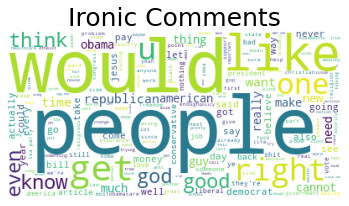

In [7]:
text_ironic = ' '.join(df.comment_text[df['label'] == 1])
wc_ironic = WordCloud(background_color='white',stopwords=STOPWORDS).generate(text_ironic)
plt.imshow(wc_ironic)
plt.axis('off')
plt.title('Ironic Comments',fontsize=25)
plt.show()

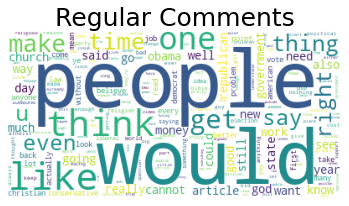

In [8]:
text = ' '.join(df.comment_text[df['label'] == -1])
wc = WordCloud(background_color='white',stopwords=STOPWORDS).generate(text)
plt.imshow(wc)
plt.axis('off')
plt.title('Regular Comments',fontsize=25)
plt.show()

In [9]:
def preprocess(sent):
    def convert(word):
        word = re.sub(r"\W+", "", word)
        # Verifica se é um número.
        try:
            _ = float(word)
            return '<num>'
        except:
            pass

        # Verifica se é uma palavra.
        if word.isalpha():
            lower = word.lower()
            return '<stop>' if lower in STOPWORDS else lower

        # Caso contrário, é pontuação ou estranho.
        return '<weird>'

    processed = [convert(word) for word in sent]
    forbidden_words = set(('<num>', '<stop>', '<weird>'))
    return [word for word in processed if word not in forbidden_words]

In [10]:
sents_all = [preprocess(item.strip().split()) for item in df.comment_text]
df['word_list'] = sents_all
df.head(3)

,comment_text,label,word_list
0,i suspect atheists are projecting their desire...,-1,"[suspect, atheists, projecting, desires, imagi..."
1,it's funny how the arguments the shills are ma...,-1,"[funny, arguments, shills, making, still, clos..."
2,we are truly following the patterns of how the...,-1,"[truly, following, patterns, mandarins, took, ..."


In [11]:
from collections import defaultdict
word_counts_ironic = defaultdict(lambda: 0)
word_counts_non_ironic = defaultdict(lambda: 0)

for i in range(len(df)):
    if df['label'][i] == 1:
        for j in df['word_list'][i]:
            word_counts_ironic[j] += 1 
    else:
        for j in df['word_list'][i]:
            word_counts_non_ironic[j] += 1
    
word_counts_ironic_sorted = sorted(word_counts_ironic.items(), key=lambda k: k[1], reverse=True)
word_counts_non_ironic_sorted = sorted(word_counts_non_ironic.items(), key=lambda k: k[1], reverse=True)

print("Most common words in ironic texts")
r = 0
k = 10
for i in range(k):
    print(word_counts_ironic_sorted[i+r])
print("=" * 80)
print("Most common words in non ironic texts")
for i in range(k):
    print(word_counts_non_ironic_sorted[i+r])

Most common words in ironic texts
('people', 70)
('would', 60)
('like', 54)
('get', 48)
('right', 39)
('us', 39)
('good', 36)
('one', 33)
('even', 33)
('know', 32)
Most common words in non ironic texts
('people', 273)
('would', 266)
('like', 238)
('think', 188)
('get', 162)
('one', 152)
('even', 121)
('really', 111)
('make', 108)
('time', 106)


### LDA

In [12]:
import pickle
from gensim.corpora import Dictionary
import gensim
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

c:\users\mathe\appdata\local\programs\python\python38\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [13]:
#Generate LDA MODEL
from gensim.models.ldamulticore import LdaMulticore
def model_dict(sents, NUM_TOPICS):
    dictionary = Dictionary(sents)
    corpus = [dictionary.doc2bow(sent) for sent in sents]

    ldamodel = LdaMulticore(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=30, random_state=42)

    return corpus, dictionary, ldamodel

In [14]:
#Check topics

def check_topics(corpus, lda_model):
    topics = lda_model.get_document_topics(corpus, per_word_topics=True)


    doc_topics, word_topics, phi_values = topics[10]
    print('Document topic:', doc_topics, "\n")

    for topic, strength in doc_topics:
        print(f'Topico: {topic}')
        print(lda_model.print_topic(topic, topn=20))

    topics = lda_model.print_topics(num_words=10)
    for topic in topics:
        print(topic)

In [15]:
def display_model(corpus, dictionary, ldamodel):  
    lda_display = pyLDAvis.gensim_models.prepare(
        ldamodel,
        corpus,
        dictionary,
        sort_topics=False,
    )
    return pyLDAvis.display(lda_display)

In [16]:
corpus_all, dictionary_all, lda_model_all = model_dict(sents_all, NUM_TOPICS=10)
# check_topics(corpus_all, lda_model_all)

In [17]:
display_model(corpus_all, dictionary_all, lda_model_all)

In [18]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
#Dominant topic in each sentence
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(lda_model_all, corpus_all, sents_all)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic['label'] = df['label']
df_dominant_topic['check'] = df['word_list'] == df_dominant_topic['Text']

df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,label,check
0,0,7.0,0.9735,"obama, people, like, get, actually, sure, make...","[suspect, atheists, projecting, desires, imagi...",-1,True
1,1,9.0,0.9791,"people, get, government, right, need, news, ti...","[funny, arguments, shills, making, still, clos...",-1,True
2,2,1.0,0.9678,"god, people, would, like, another, think, well...","[truly, following, patterns, mandarins, took, ...",-1,True
3,3,6.0,0.9640,"would, like, party, youth, think, church, one,...","[air, pressure, dropping, altitude, goes, high...",-1,True
4,4,5.0,0.9591,"would, like, think, people, day, time, much, g...","[absolutely, think, wed, hard, pressed, find, ...",-1,True


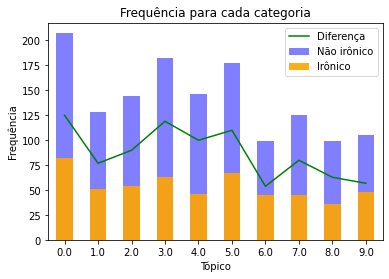

In [19]:
ironic = df_dominant_topic[df_dominant_topic['label'] == 1]
nonIronic = df_dominant_topic[df_dominant_topic['label'] == -1]

fig, ax = plt.subplots()
nonIronic['Dominant_Topic'].value_counts().sort_index().plot(kind='bar', color='b', label='Não irônico', alpha=0.5)
ironic['Dominant_Topic'].value_counts().sort_index().plot(kind='bar', color='orange', label='Irônico', alpha=0.9)
(nonIronic['Dominant_Topic'].value_counts().sort_index() - ironic['Dominant_Topic'].value_counts().sort_index()).plot(color='g', label='Diferença')
plt.ylabel('Frequência')
plt.xlabel('Tópico')
plt.legend()
plt.title("Frequência para cada categoria")
plt.show()

In [20]:
#Dominant topics occurences
df_dominant_topic.Dominant_Topic.value_counts()

#Dominant topic with most occurences
dominant_topic = df_dominant_topic.Dominant_Topic.value_counts().index[0]

#Documents related to dominant topic with most occurences
df_dominant_topic[df_dominant_topic.Dominant_Topic == dominant_topic].head(3)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,label,check
8,8,0.0,0.8714,"would, people, know, get, like, think, right, ...","[yeah, get, far, article, fills, sadness]",-1,True
16,16,0.0,0.9181,"would, people, know, get, like, think, right, ...","[reddit, liberal, brigade, would, downvote, ob...",1,True
29,29,0.0,0.6999,"would, people, know, get, like, think, right, ...","[sure, pass]",1,True


In [21]:
#Most representative document for each topic
representativeDoc = pd.DataFrame()

groupByDominantTopic = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in groupByDominantTopic:
    representativeDoc = pd.concat([representativeDoc, 
                        grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                        axis=0)

# Reset Index    
representativeDoc.reset_index(drop=True, inplace=True)

# Format
representativeDoc.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
representativeDoc

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9958,"would, people, know, get, like, think, right, ...","[solution, constant, upward, pressure, creatin..."
1,1.0,0.9957,"god, people, would, like, another, think, well...","[one, example, patient, suffering, sleep, apne..."
2,2.0,0.9945,"people, even, get, one, would, way, like, much...","[think, article, vague, specific, enough, soci..."
3,3.0,0.9975,"people, would, like, think, government, one, w...","[prefer, texan, back, horrible, kidney, stone,..."
4,4.0,0.9938,"would, good, like, us, one, people, years, sai...","[membership, elite, group, likely, come, invol..."
5,5.0,0.9942,"would, like, think, people, day, time, much, g...","[meaningless, words, around, false, dichotomy,..."
6,6.0,0.9944,"would, like, party, youth, think, church, one,...","[pathetic, many, levels, imagine, subconscious..."
7,7.0,0.9918,"obama, people, like, get, actually, sure, make...","[many, places, bad, idea, though, example, pro..."
8,8.0,0.9973,"money, people, like, get, would, could, us, en...","[infuriates, people, reddit, use, tired, old, ..."
9,9.0,0.9969,"people, get, government, right, need, news, ti...","[sick, tired, whole, media, cabal, bullshit, e..."


In [22]:
for i in range(len(representativeDoc)):
    print(f"Topic {i}\n", " ".join(representativeDoc["Text"][i]))
    print('=' * 80)

Topic 0
 solution constant upward pressure creating money nothing constantly inflating since deflation catastrophic often conclusion keynesiannew economics argument began people need wealth trade wealth central banking system new money printed drive interest rates allowing companies expand raise wages faster would otherwise able pay government programs fall short budgeting balance thrown new money system amount wealth works great first creating boom eventually market catches fact people trading paper money amount stuff contraction bust often hard argue statement populist setting since said essentially true people money spend money taken account french economist frederic bastiat called seen unseen would reccomend reading essay name seriously considerin implications used think along lines read would also point small medium sized businesses create jobs new businesses therefore best path future job creation however seem possibly indirectly arguing demand side limitations hinders someone ac